# A socio-economic projection
This code produces a projection of the Danish population divided into socio-economic groups to 2060 using the Register-based Labour Force Statistics (RAS) and the population projection from Statistics Denmark. The code is structured in three main elements:

1. Packages
2. Data
3. Projection

The principle behind the projection is that the number of people in a given socio-economic group $a$ at time $t$ is found by multiplying the population at time $t$ with the share of people in the given socio-economic group in a base-year $\bar{t}$:

$$ a(i,s,t) = freq(i,s,\bar{t}) \cdot pop(i,t) $$

$a(i,s,t)$ denotes the number of persons in the demographic group $i$ at time $t$, who are in the socio-economic group $s$. $freq(i,s,\bar{t})$ is the freqency of the socio-economic group $s$ in the demographic group $i$ in a given base year $\bar{t}$. $pop(i,t)$ is the population in the dempgraphic group $i$ at time $t$.

We construct $freq(i,s,\bar{t})$ and $pop(i,t)$ in the data section using the population projection and RAS from Statistics Denmark. In the projection section of the code we find $a(i,s,t)$, define a "contributer-fraction", and show how the Danish economy wil develop if behavior in 2017 (RAS) is projected into the future using the population projection.

## Packages
We'll need some packages to do some dirty work for us.

In [2]:
import requests                 # Needed to download data from Statistics Denmark's API
import io                       # Also needed to download data from Statistics Denmark's API
import pandas            as pd  # Pandas - because everybody loves pandas
import numpy             as np  # Numpy  - just because
import matplotlib.pyplot as plt # To draw graphs 'n' stuff
import ipywidgets        as wd  # To draw interactive graphs 'n' stuff

## Data
Now we are ready to stream some data! We'll need the tables RAS205, FOLK2 and FRDK118. FOLK2 is the historic population. It is included to put our results into a historic perspectiv.

In [3]:
## Calling Statistics Denmark's API and retrieving the RAS205 table as a CSV-file
url_RAS = 'https://api.statbank.dk/v1/data/RAS205/CSV?valuePresentation=Code&delimiter=Semicolon&OPRINDLAND=30%2C32%2C34%2C36%2C38&SOCIO=*&ALDER=*&K%C3%98N=*&TID=*'
RAS = requests.get(url_RAS).content
RAS = pd.read_csv(io.StringIO(RAS.decode('utf-8')),sep=";")

## Calling Statistics Denmarks's API and retrieving the FOLK2 table as a CSV-file
url_FOLK = 'https://api.statbank.dk/v1/data/FOLK2/CSV?valuePresentation=Code&delimiter=Semicolon&ALDER=*&K%C3%98N=*&HERKOMST=*&IELAND=*&Tid=2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017'
FOLK = requests.get(url_FOLK).content
FOLK = pd.read_csv(io.StringIO(FOLK.decode('utf-8')),sep=";")

## Calling Statistics Denmarks's API and retrieving the FRDK118 table as a CSV-file
url_FRDK = 'https://api.statbank.dk/v1/data/FRDK118/CSV?valuePresentation=Code&delimiter=Semicolon&HERKOMST=*&K%C3%98N=*&ALDER=*&Tid=*'
FRDK = requests.get(url_FRDK).content
FRDK = pd.read_csv(io.StringIO(FRDK.decode('utf-8')),sep=";")

The next step is to define some variables, which we can use for our projections! We are going to construct the following variables:

* year
* gender
* age
* origin - danish, immigrant, or descendant
* activ (socio-economic groups)
* freq (frequencies)
* pop (population)

### The Register-based Labour Force Statistics (RAS)
We construct our $freq(i,s,\bar{t})$ using RAS. The final RAS-dataset contains:
* year
* gender
* age
* origin - danish, immigrant, or descendant
* activ (socio-economic groups)
* freq (frequencies)

In [4]:
## Renaming the columns
RAS.rename(columns = {'OPRINDLAND':'origin','SOCIO':'activ','ALDER':'age','KØN':'gender','TID':'year','INDHOLD':'pop'}, inplace = True)

## Year - years are integers
RAS['year'] = RAS['year'].astype(int)

## Gender - a character - m=male, and f=female
RAS.loc[RAS.gender=="M", 'gender'] = 'm'
RAS.loc[RAS.gender=="K", 'gender'] = 'f'

## Age - we'll do some magic later

## Origin - a character
RAS["origin"] = RAS["origin"].astype(str)
RAS.loc[RAS.origin=="30", 'origin'] = 'da' # da = danish
RAS.loc[RAS.origin=="32", 'origin'] = 'dw' # dw = descendant from a western country
RAS.loc[RAS.origin=="34", 'origin'] = 'dx' # dx = descendant from a non-western country
RAS.loc[RAS.origin=="36", 'origin'] = 'iw' # iw = immigrant from a western country
RAS.loc[RAS.origin=="38", 'origin'] = 'ix' # ix = immigrant from a non-western country

## Activ - the socio-economic group

# Subsetting the dataframe into two - one with total population RAS_tot
RAS_tot = RAS.loc[RAS.activ == "TOT"]
RAS_tot = RAS_tot.drop(columns = ['activ'])

# and one with all activ-groups
RAS = RAS.loc[RAS.activ != "TOT"]
RAS.rename(columns = {'pop':'n'}, inplace = True)

# renaming activ-groups
RAS['activ'] = RAS['activ'].astype(int)
RAS['activ2'] = "NA" 
RAS.loc[(RAS.activ >= 5)   &  (RAS.activ <= 40) ,'activ2'] = "emp"  # emp  = employed
RAS.loc[(RAS.activ == 50)                       ,'activ2'] = "uemp" # uemp = unemployed
RAS.loc[(RAS.activ >= 80)  & (RAS.activ <= 128) ,'activ2'] = "oulb" # oulb = outside labour force on public income
RAS.loc[(RAS.activ == 130) | (RAS.activ == 154) | (RAS.activ == 156) | (RAS.activ == 158) | (RAS.activ == 160),'activ2'] = "educ" # educ = in education
RAS.loc[(RAS.activ == 135) | (RAS.activ == 140) | (RAS.activ == 145) | (RAS.activ == 150) | (RAS.activ == 155),'activ2'] = "pens" # pens = pensioner (including early retirement schemes)
RAS.loc[(RAS.activ == 170)                      ,'activ2'] = "chld" # chld = child
RAS.loc[(RAS.activ == 175)                      ,'activ2'] = "othr" # othr = others

RAS['activ'] = RAS['activ2']
RAS = RAS.drop(columns = ['activ2'])

# Aggregating over activ-groups
RAS = RAS.groupby(['year','gender','age','origin','activ'],as_index=False).sum()

## Freq - the share of a group defined by year, gender, age, and origin in an activ-group
RAS = pd.merge(RAS,RAS_tot,on=['year','gender','age','origin'])
RAS['freq'] = RAS['n'] / RAS['pop']
RAS = RAS.drop(columns = ['n','pop'])

## Some magic regarding age
# Splitting the age-interval-string into a minimum age and maximum age in the interval
RAS[['min_age','max_age']] = RAS['age'].str.split("-",n=1,expand=True)
RAS.loc[RAS.min_age == "",'min_age'] = "0"  
RAS.loc[RAS.max_age == "",'max_age'] = "125" 

# Calculating the number of years in the age interval
RAS['min_age'] = RAS['min_age'].astype(int)
RAS['max_age'] = RAS['max_age'].astype(int)
RAS['expand'] = RAS['max_age'] - RAS['min_age'] + 1

# Creating a row per year in the interval
RAS = RAS.loc[np.repeat(RAS.index.values, RAS.expand)]

#Counting the rows and creating af new age variable equal to the age variable in the population projection
RAS['seq'] = RAS.groupby(['year','gender','age','origin','activ']).cumcount()
RAS['seq'] = RAS['min_age']+RAS['seq']
RAS = RAS.drop(columns = ['age','expand','min_age','max_age'])
RAS.rename(columns = {'seq':'age'}, inplace = True)

## You are a child if you are under 17 - we do not condone child labour in our projections
RAS.loc[(RAS.age < 17) & (RAS.activ == "chld"),'freq'] = 1
RAS.loc[(RAS.age < 17) & (RAS.activ != "chld"),'freq'] = 0

## Rearranging the columns
cols = ['year','gender','age','origin','activ','freq']
RAS = RAS[cols]

### The historic population (FOLK)
We construct our $pop(i,s,\bar{t})$ in the historic years using FOLK. The final FOLK-dataset contains:
* year
* gender
* age
* origin - danish, immigrant, or descendant
* activ (socio-economic groups)
* pop (historic population)

In [5]:
## Renaming the columns
FOLK.rename(columns = {'HERKOMST':'origin','ALDER':'age','KØN':'gender','TID':'year','INDHOLD':'pop'}, inplace = True)

## Year - already an integer

## Gender - a character - m=male, and f=female
FOLK.loc[FOLK.gender=="M", 'gender'] = 'm'
FOLK.loc[FOLK.gender=="K", 'gender'] = 'f'

## Age - already an integer

## Origin
FOLK['origin'] = FOLK['origin'].astype(str)

# Lists with all western and non-western countries
iw = [5100,5124,5126,5128,5422,5607,5104,5130,5134,5142,5105,5150,5750,5609,5107,5611,5108,5153,5109,5140,5111,5110,5154,5156,5158,5159,5160,5778,5752,5164,5170,5120,5776,5129,5184,5180,5174,5176,5182,5314,5390,5397,5502,5514]
ix = [5122,5754,5706,5152,5758,5761,5756,5712,5759,5700,5757,5151,5162,5172,5704,5114,5202,5204,5281,5207,5294,5213,5277,5276,5215,5278,5279,5525,5272,5282,5216,5214,5283,5222,5228,5232,5231,5233,5234,5235,5236,5238,5242,5297,5243,5244,5284,5245,5240,5247,5285,5246,5286,5287,5621,5288,5298,5255,5289,5256,5253,5258,5259,5262,5260,5264,5266,5292,5293,5268,5269,5296,5295,5230,5299,5309,5302,5301,5303,5305,5526,5307,5304,5306,5394,5316,5318,5322,5324,5325,5345,5326,5328,5372,5530,5529,5336,5339,5528,5338,5308,5342,5346,5348,5352,5353,5354,5310,5356,5358,5364,5366,5527,5625,5347,5311,5344,5374,5376,5392,5395,5319,5535,5404,5708,5710,5406,5410,5408,5412,5416,5531,5474,5403,5724,5428,5432,5498,5434,5436,5438,5442,5444,5446,5716,5448,5720,5452,5454,5456,5533,5458,5457,5487,5459,5414,5464,5466,5462,5472,5473,5496,5478,5480,5482,5418,5484,5486,5722,5424,5492,5493,5718,5714,5468,5494,5402,5471,5516,5508,5506,5274,5248,5534,5623,5522,5505,5273,5275,5532,5599,5103,5999]

# Defining origin
FOLK.loc[(FOLK.origin == "5")                         ,'origin'] = "da" # da = danish
FOLK.loc[(FOLK.origin == "3") & (FOLK.IELAND.isin(ix)),'origin'] = "dx" # dw = descendant from a western country
FOLK.loc[(FOLK.origin == "3") & (FOLK.IELAND.isin(iw)),'origin'] = "dw" # dx = descendant from a non-western country
FOLK.loc[(FOLK.origin == "4") & (FOLK.IELAND.isin(ix)),'origin'] = "ix" # iw = immigrant from a western country
FOLK.loc[(FOLK.origin == "4") & (FOLK.IELAND.isin(iw)),'origin'] = "iw" # ix = immigrant from a non-western country
FOLK = FOLK.drop(columns = ['IELAND'])

# Aggregating on year, gender, age, and origin
FOLK = FOLK.groupby(['year','gender','age','origin'],as_index=False).sum()

## Rearranging the columns
cols = ['year','gender','age','origin','pop']
FOLK = FOLK[cols]

### The population projection (FRDK)
We construct our $pop(i,s,\bar{t})$ in the projectionc years using FRDK. The final FRDK-dataset contains:
* year
* gender
* age
* origin - danish, immigrant, or descendant
* activ (socio-economic groups)
* pop (historic population)

In [6]:
## Renaming the columns
FRDK.rename(columns = {'HERKOMST':'origin','ALDER':'age','KØN':'gender','TID':'year','INDHOLD':'pop'}, inplace = True)

## Year - already an integer

## Gender - a character - m=male, and f=female
FRDK.loc[FRDK.gender=="M", 'gender'] = 'm'
FRDK.loc[FRDK.gender=="K", 'gender'] = 'f'

## Age - already an integer

## Origin
FRDK["origin"] = FRDK["origin"].astype(str)
FRDK.loc[FRDK.origin=="999", 'origin'] = 'da' # da = danish
FRDK.loc[FRDK.origin=="24" , 'origin'] = 'dw' # dw = descendant from a western country
FRDK.loc[FRDK.origin=="25" , 'origin'] = 'dx' # dx = descendant from a non-western country
FRDK.loc[FRDK.origin=="34" , 'origin'] = 'iw' # iw = immigrant from a western country
FRDK.loc[FRDK.origin=="35" , 'origin'] = 'ix' # ix = immigrant from a non-western country

## Population - already an integer

## Rearranging the columns
cols = ['year','gender','age','origin','pop']
FRDK = FRDK[cols]

## Projection
First we find the number of people in different socio-economic groups. Recall that $ a(i,s,t) = freq(i,s,\bar{t}) \cdot pop(i,t)$. 

In [7]:
## Creating a projection year
RAS['proj_year']  = RAS['year']
RAS = RAS.drop(columns = ['year'])
FOLK['proj_year'] = FOLK['year']
FRDK['proj_year'] = FRDK['year']

## Combining the historic population with the population projection (FOLK and FRDK)
proj = FOLK.append(FRDK)
proj = proj.sort_values(by=['year','proj_year','gender','age','origin'])

## Ensuring that \bar{t} equals 2017
proj.loc[proj.proj_year > 2017,'proj_year'] = 2017

## Merges with RAS and find a(i,s,t). a(i,s,t) is the variable 'pop' in the projection dataset 'proj'
proj = pd.merge(proj,RAS,on=['proj_year','gender','age','origin'])
proj['pop'] = proj['pop'] * proj['freq']

## Aggregating to a yearly level on activ-groups
proj = proj.groupby(['year','age','activ'],as_index=False).sum()
proj = proj.drop(columns = ['proj_year','freq'])

### The "contributer-fraction"
The contributer-fraction shows how many unemploy or otherwise non-working persons there is for each employed person. It is a modified version of the "forsørgerbrøk". 

$$ contributer\text{-}fraction = \frac{non\text{-}working}{working}$$


C:\Python\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


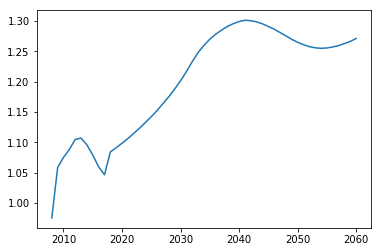

In [8]:
## Creating a contributer-dataframe 'cont'
cont = proj.copy()

## Share of people working relativ to not working
cont.loc[cont.activ=="emp" ,'activ'] = "work"
cont.loc[cont.activ!="work",'activ'] = "notwork"

## Aggregating on a yearly level
cont = cont.groupby(['year','activ'],as_index=False).sum()
cont = cont.drop(columns = ['age'])

## Finding the numer of working and non-working people in the projection
cont_work = cont.loc[cont.activ == "work"]
cont_work.rename(columns = {'pop':'work'}, inplace = True)
cont_work = cont_work.drop(columns = ['activ'])
cont_notwork = cont.loc[cont.activ == "notwork"]
cont_notwork.rename(columns = {'pop':'notwork'}, inplace = True)
cont_notwork = cont_notwork.drop(columns = ['activ'])

## Finding the contributer fraction
cont = pd.merge(cont_work,cont_notwork,on=['year'])
cont['cfrc'] = cont['notwork'] / cont['work'] 

## Plotting the contributer fraction
year = cont['year'].values
cfrc = cont['cfrc'].values

plt.plot(year,cfrc)
plt.show()


Our results show that the contributer fraction is rising in the future. Each employed person has to contribute with more in the future to support the increasing number of non-working people.

### Why is the contributer fraction rising
We present our results in a bar chart and as a forsørger-brøk. It will be "meget meget dyrt" in the future!

In [9]:
## Creating an interactiv figure
def plot_a_year(y):
    # Creating an array for each socio-economic group
    plotdata = proj.loc[proj.year == y]
    chld = plotdata.loc[plotdata.activ == "chld",'pop'].values / 1000
    emp  = plotdata.loc[plotdata.activ == "emp" ,'pop'].values / 1000
    uemp = plotdata.loc[plotdata.activ == "uemp",'pop'].values / 1000
    oulb = plotdata.loc[plotdata.activ == "oulb",'pop'].values / 1000
    educ = plotdata.loc[plotdata.activ == "educ",'pop'].values / 1000
    pens = plotdata.loc[plotdata.activ == "pens",'pop'].values / 1000
    othr = plotdata.loc[plotdata.activ == "othr",'pop'].values / 1000
    
    # Creating a stacked bar graph
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.bar(np.arange(126),chld,width=1,                                     label = 'Children')
    ax.bar(np.arange(126),emp ,width=1,bottom=chld,                         label = 'Employed')
    ax.bar(np.arange(126),uemp,width=1,bottom=chld+emp,                     label = 'Unemployed')
    ax.bar(np.arange(126),oulb,width=1,bottom=chld+emp+uemp,                label = 'Outside labour force')
    ax.bar(np.arange(126),educ,width=1,bottom=chld+emp+uemp+oulb,           label = 'In education')
    ax.bar(np.arange(126),pens,width=1,bottom=chld+emp+uemp+oulb+educ,      label = 'Pensioners')
    ax.bar(np.arange(126),othr,width=1,bottom=chld+emp+uemp+oulb+educ+pens, label = 'Others')
    ax.set_ylim([0,90])
    ax.set_xlim([0,110])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('1,000 persons')
    plt.xlabel('Age')
    
## Trying the plot
wd.interact(plot_a_year,
    y=wd.IntSlider(description="year", min=2008, max=2060, step=1, value=2008),
);

interactive(children=(IntSlider(value=2008, description='year', max=2060, min=2008), Output()), _dom_classes=(…

By shifting the year from 2008 to 2060 it is easily seen that the contributer fraction is increasing due to an ageing population. The non-working share of the population will outgrow the working share of the population if the retirement age is kept fixed at 2017-levels (65-years).